In [1]:
%matplotlib inline

In [2]:
# -*- coding: utf-8 -*-
"""
@author: Hiromasa Kaneko
課題15: 課題14と同様にPLSモデルを構築せよ。さらに、k最近傍法(k-nearest neighbor, kNN)によりモデルの適用範囲
(Applicability Domain, AD)を設定せよ。そしてkの値を変えながら、ADの内側と外側とでテストデータのr2, RMSE, MEAを計算して
比較し、考察せよ。また実測値と予測値とのプロットも確認すること。
"""

import matplotlib.figure as figure
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from sklearn import model_selection
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression

regression_method_flag = 2  # 1:OLS, 2:PLS(constant component number), 3:PLS,
pls_component_number = 2
max_pls_component_number = 50
fold_number = 2
threshold_of_rate_of_same_value = 0.79
do_autoscaling = True  # True or False
number_of_training_data = 878  # if this is the number of all samples, there are no test samples.
k_in_kNN = 10
ratio_of_training_samples_in_ad = 0.997




In [3]:
# load data set
raw_data_with_y = pd.read_csv('logSdataset1290.csv', encoding='SHIFT-JIS', index_col=0)
raw_data_with_y = raw_data_with_y.drop(['Ipc', 'Kappa3'], axis=1)  # Ipc:1139だけ外れ値をもつ記述子、
# Kappa3:889だけ外れ値をもつ記述子

# delete duplicates
# raw_data_with_y = raw_data_with_y.drop( raw_data_with_y.index[raw_data_with_y.index.duplicated()] ) #重複したサンプルの
# 最初を残す
# raw_data_with_y = raw_data_with_y.drop( raw_data_with_y.index[raw_data_with_y.index.duplicated(keep=False)] ) #重複した
# サンプルはすべて削除

ytrain = raw_data_with_y.iloc[:number_of_training_data, 0]
raw_Xtrain = raw_data_with_y.iloc[:number_of_training_data, 1:]
ytest = raw_data_with_y.iloc[number_of_training_data:, 0]
raw_Xtest = raw_data_with_y.iloc[number_of_training_data:, 1:]

# delete descriptors with high rate of the same values
rate_of_same_value = list()
num = 0
for X_variable_name in raw_Xtrain.columns:
    num += 1
    print('{0} / {1}'.format(num, raw_Xtrain.shape[1]))
    same_value_number = raw_Xtrain[X_variable_name].value_counts()
    rate_of_same_value.append(float(same_value_number[same_value_number.index[0]] / raw_Xtrain.shape[0]))
deleting_variable_numbers = np.where(np.array(rate_of_same_value) >= threshold_of_rate_of_same_value)

"""
# delete descriptors with zero variance
deleting_variable_numbers = np.where( raw_Xtrain.var() == 0 )
"""

if len(deleting_variable_numbers[0]) == 0:
    Xtrain = raw_Xtrain.copy()
    Xtest = raw_Xtest.copy()
else:
    Xtrain = raw_Xtrain.drop(raw_Xtrain.columns[deleting_variable_numbers], axis=1)
    Xtest = raw_Xtest.drop(raw_Xtest.columns[deleting_variable_numbers], axis=1)
    print('Variable numbers zero variance: {0}'.format(deleting_variable_numbers[0] + 1))

print('# of X-variables: {0}'.format(Xtrain.shape[1]))



1 / 194
2 / 194
3 / 194
4 / 194
5 / 194
6 / 194
7 / 194
8 / 194
9 / 194
10 / 194
11 / 194
12 / 194
13 / 194
14 / 194
15 / 194
16 / 194
17 / 194
18 / 194
19 / 194
20 / 194
21 / 194
22 / 194
23 / 194
24 / 194
25 / 194
26 / 194
27 / 194
28 / 194
29 / 194
30 / 194
31 / 194
32 / 194
33 / 194
34 / 194
35 / 194
36 / 194
37 / 194
38 / 194
39 / 194
40 / 194
41 / 194
42 / 194
43 / 194
44 / 194
45 / 194
46 / 194
47 / 194
48 / 194
49 / 194
50 / 194
51 / 194
52 / 194
53 / 194
54 / 194
55 / 194
56 / 194
57 / 194
58 / 194
59 / 194
60 / 194
61 / 194
62 / 194
63 / 194
64 / 194
65 / 194
66 / 194
67 / 194
68 / 194
69 / 194
70 / 194
71 / 194
72 / 194
73 / 194
74 / 194
75 / 194
76 / 194
77 / 194
78 / 194
79 / 194
80 / 194
81 / 194
82 / 194
83 / 194
84 / 194
85 / 194
86 / 194
87 / 194
88 / 194
89 / 194
90 / 194
91 / 194
92 / 194
93 / 194
94 / 194
95 / 194
96 / 194
97 / 194
98 / 194
99 / 194
100 / 194
101 / 194
102 / 194
103 / 194
104 / 194
105 / 194
106 / 194
107 / 194
108 / 194
109 / 194
110 / 194
111 / 19

In [4]:
# autoscaling
if do_autoscaling:
    autoscaled_Xtrain = (Xtrain - Xtrain.mean(axis=0)) / Xtrain.std(axis=0, ddof=1)
    autoscaled_ytrain = (ytrain - ytrain.mean()) / ytrain.std(ddof=1)
    autoscaled_Xtest = (Xtest - Xtrain.mean(axis=0)) / Xtrain.std(axis=0, ddof=1)
else:
    autoscaled_Xtrain = Xtrain.copy()
    autoscaled_ytrain = ytrain.copy()
    autoscaled_Xtest = Xtest.copy()



In [5]:
if regression_method_flag == 1:  # Ordinary Least Squares
    regression_model = LinearRegression()
    
elif regression_method_flag == 2:  # Partial Least Squares with constant component
    regression_model = PLSRegression(n_components=pls_component_number)
    
elif regression_method_flag == 3:  # Partial Least Squares
    pls_components = np.arange(1, min(np.linalg.matrix_rank(autoscaled_Xtrain) + 1, max_pls_component_number + 1), 1)
    r2all = list()
    r2cvall = list()
    for pls_component in pls_components:
        pls_model_in_cv = PLSRegression(n_components=pls_component)
        pls_model_in_cv.fit(autoscaled_Xtrain, autoscaled_ytrain)
        calculated_y_in_cv = np.ndarray.flatten(pls_model_in_cv.predict(autoscaled_Xtrain))
        estimated_y_in_cv = np.ndarray.flatten(
            model_selection.cross_val_predict(pls_model_in_cv, autoscaled_Xtrain, autoscaled_ytrain, cv=fold_number))
        if do_autoscaling:
            calculated_y_in_cv = calculated_y_in_cv * ytrain.std(ddof=1) + ytrain.mean()
            estimated_y_in_cv = estimated_y_in_cv * ytrain.std(ddof=1) + ytrain.mean()

        """
        plt.figure(figsize=figure.figaspect(1))
        plt.scatter( y, estimated_y_in_cv)
        plt.xlabel("Actual Y")
        plt.ylabel("Calculated Y")
        plt.show()
        """
        r2all.append(float(1 - sum((ytrain - calculated_y_in_cv) ** 2) / sum((ytrain - ytrain.mean()) ** 2)))
        r2cvall.append(float(1 - sum((ytrain - estimated_y_in_cv) ** 2) / sum((ytrain - ytrain.mean()) ** 2)))
        
    plt.plot(pls_components, r2all, 'bo-')
    plt.plot(pls_components, r2cvall, 'ro-')
    plt.ylim(0, 1)
    plt.xlabel('Number of PLS components')
    plt.ylabel('r2(blue), r2cv(red)')
    plt.show()
    optimal_pls_component_number = np.where(r2cvall == np.max(r2cvall))
    optimal_pls_component_number = optimal_pls_component_number[0][0] + 1
    regression_model = PLSRegression(n_components=optimal_pls_component_number)

regression_model.fit(autoscaled_Xtrain, autoscaled_ytrain)



PLSRegression(copy=True, max_iter=500, n_components=2, scale=True, tol=1e-06)

In [6]:
# calculate y
calculated_ytrain = np.ndarray.flatten(regression_model.predict(autoscaled_Xtrain))

if do_autoscaling:
    calculated_ytrain = calculated_ytrain * ytrain.std(ddof=1) + ytrain.mean()

# set AD
distance_between_autoscaled_Xtrain = cdist(autoscaled_Xtrain, autoscaled_Xtrain)
distance_between_autoscaled_Xtrain.sort()
knn_distance = np.mean(distance_between_autoscaled_Xtrain[:, 1:k_in_kNN + 1], axis=1)
# set AD threshold
knn_distance.sort()
ad_threshold = knn_distance[round(autoscaled_Xtrain.shape[0] * ratio_of_training_samples_in_ad) - 1]

# r2
print('r2: {0}'.format(float(1 - sum((ytrain - calculated_ytrain) ** 2) / sum((ytrain - ytrain.mean()) ** 2))))



r2: 0.8026268539925738


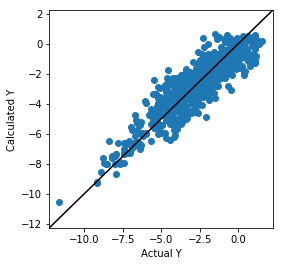

In [7]:
# yy-plot
plt.figure(figsize=figure.figaspect(1))
plt.scatter(ytrain, calculated_ytrain)
YMax = np.max(np.array([np.array(ytrain), calculated_ytrain]))
YMin = np.min(np.array([np.array(ytrain), calculated_ytrain]))
plt.plot([YMin - 0.05 * (YMax - YMin), YMax + 0.05 * (YMax - YMin)],
         [YMin - 0.05 * (YMax - YMin), YMax + 0.05 * (YMax - YMin)], 'k-')
plt.ylim(YMin - 0.05 * (YMax - YMin), YMax + 0.05 * (YMax - YMin))
plt.xlim(YMin - 0.05 * (YMax - YMin), YMax + 0.05 * (YMax - YMin))
plt.xlabel('Actual Y')
plt.ylabel('Calculated Y')
plt.show()



In [8]:
# standard regression coefficients
standard_regression_coefficients = regression_model.coef_
standard_regression_coefficients = pd.DataFrame(standard_regression_coefficients)
standard_regression_coefficients.index = Xtrain.columns
standard_regression_coefficients.columns = ['standard regression coefficient']
standard_regression_coefficients.to_csv('standard_regression_coefficients.csv')

# prediction
predicted_ytest = np.ndarray.flatten(regression_model.predict(autoscaled_Xtest))
if do_autoscaling:
    predicted_ytest = predicted_ytest * ytrain.std(ddof=1) + ytrain.mean()

In [9]:
# AD check
distance_between_autoscaled_Xtrain_Xtest = cdist(autoscaled_Xtest, autoscaled_Xtrain)
distance_between_autoscaled_Xtrain_Xtest.sort()
knn_distance_test = np.mean(distance_between_autoscaled_Xtrain_Xtest[:, 0:k_in_kNN], axis=1)

# statistics and yy-plot
ytest_inside_ad = ytest[knn_distance_test <= ad_threshold]
predicted_ytest_inside_ad = predicted_ytest[knn_distance_test <= ad_threshold]
ytest_outside_ad = ytest[knn_distance_test > ad_threshold]
predicted_ytest_outside_ad = predicted_ytest[knn_distance_test > ad_threshold]


r2p inside of AD: 0.8289874109042935
RMSEp inside of AD: 0.8595712465533538
MAEp inside of AD: 0.6709232884947869


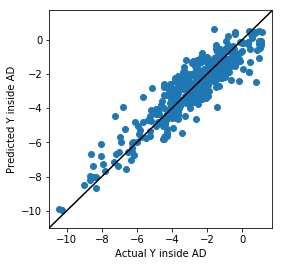

In [10]:
if ytest_inside_ad.shape[0] > 0:
    print('r2p inside of AD: {0}'.format(float(
        1 - sum((ytest_inside_ad - predicted_ytest_inside_ad) ** 2) / sum(
            (ytest_inside_ad - ytest_inside_ad.mean()) ** 2))))
    print('RMSEp inside of AD: {0}'.format(
        float((sum((ytest_inside_ad - predicted_ytest_inside_ad) ** 2) / ytest_inside_ad.shape[0]) ** 0.5)))
    print('MAEp inside of AD: {0}'.format(
        float(sum(abs(ytest_inside_ad - predicted_ytest_inside_ad)) / ytest_inside_ad.shape[0])))
    # yy-plot inside AD
    plt.figure(figsize=figure.figaspect(1))
    plt.scatter(ytest_inside_ad, predicted_ytest_inside_ad)
    YMax = np.max(np.array([np.array(ytest_inside_ad), predicted_ytest_inside_ad]))
    YMin = np.min(np.array([np.array(ytest_inside_ad), predicted_ytest_inside_ad]))
    plt.plot([YMin - 0.05 * (YMax - YMin), YMax + 0.05 * (YMax - YMin)],
             [YMin - 0.05 * (YMax - YMin), YMax + 0.05 * (YMax - YMin)], 'k-')
    plt.ylim(YMin - 0.05 * (YMax - YMin), YMax + 0.05 * (YMax - YMin))
    plt.xlim(YMin - 0.05 * (YMax - YMin), YMax + 0.05 * (YMax - YMin))
    plt.xlabel('Actual Y inside AD')
    plt.ylabel('Predicted Y inside AD')
    plt.show()



r2p outside of AD: -11.978379232520986
RMSEp outside of AD: 2.1975565777519948
MAEp outside of AD: 2.0903943022157714


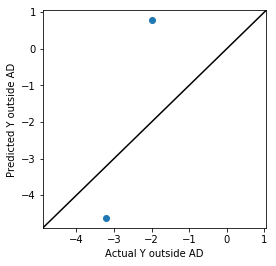

In [11]:
if ytest_outside_ad.shape[0] > 0:
    print('r2p outside of AD: {0}'.format(float(1 - sum((ytest_outside_ad - predicted_ytest_outside_ad) ** 2) / sum(
        (ytest_outside_ad - ytest_outside_ad.mean()) ** 2))))
    print('RMSEp outside of AD: {0}'.format(
        float((sum((ytest_outside_ad - predicted_ytest_outside_ad) ** 2) / ytest_outside_ad.shape[0]) ** 0.5)))
    print('MAEp outside of AD: {0}'.format(
        float(sum(abs(ytest_outside_ad - predicted_ytest_outside_ad)) / ytest_outside_ad.shape[0])))
    # yy-plot inside AD
    plt.figure(figsize=figure.figaspect(1))
    plt.scatter(ytest_outside_ad, predicted_ytest_outside_ad)
    YMax = np.max(np.array([np.array(ytest_outside_ad), predicted_ytest_outside_ad]))
    YMin = np.min(np.array([np.array(ytest_outside_ad), predicted_ytest_outside_ad]))
    plt.plot([YMin - 0.05 * (YMax - YMin), YMax + 0.05 * (YMax - YMin)],
             [YMin - 0.05 * (YMax - YMin), YMax + 0.05 * (YMax - YMin)], 'k-')
    plt.ylim(YMin - 0.05 * (YMax - YMin), YMax + 0.05 * (YMax - YMin))
    plt.xlim(YMin - 0.05 * (YMax - YMin), YMax + 0.05 * (YMax - YMin))
    plt.xlabel('Actual Y outside AD')
    plt.ylabel('Predicted Y outside AD')
    plt.show()